In [5]:
import pandas as pd
import numpy as np
from cleantext import clean
import re
from transformers import XLNetTokenizer, XLNetForSequenceClassification, TrainingArguments, Trainer, Pipeline
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import datasets
import evaluate
import random

In [6]:
data_train = pd.read_csv('/content/emotion-labels-train.csv')
data_test = pd.read_csv('/content/emotion-labels-test.csv')
data_val = pd.read_csv('/content/emotion-labels-val.csv')

In [2]:
%pip install cleantext

After installing the library, you can run the import cell again.

In [4]:
%pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.9 MB/s eta 0:00:00


CODE FROM HERE

In [7]:
data_train.head()

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy


In [8]:
data = pd.concat([data_train, data_test, data_val], ignore_index=True)

In [14]:
data['text_clean'] = data['text'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

In [15]:
data['text_clean'] = data['text_clean'].apply(lambda x: re.sub('@[^\s]+','',x))

In [16]:
data.head(20)

,text,label,text_clean
0,Just got back from seeing @GaryDelaney in Burs...,joy,Just got back from seeing in Burslem. AMAZING...
1,Oh dear an evening of absolute hilarity I don'...,joy,Oh dear an evening of absolute hilarity I don'...
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy,Been waiting all week for this game #cheer #f...
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,": Thank you so much, Gloria! You're so sweet,..."
4,I feel so blessed to work with the family that...,joy,I feel so blessed to work with the family that...
5,"Today I reached 1000 subscribers on YT!! , #go...",joy,"Today I reached 1000 subscribers on YT!! , #go..."
6,"@Singaholic121 Good morning, love! Happy first...",joy,"Good morning, love! Happy first day of fall. ..."
7,#BridgetJonesBaby is the best thing I've seen ...,joy,#BridgetJonesBaby is the best thing I've seen ...
8,Just got back from seeing @GaryDelaney in Burs...,joy,Just got back from seeing in Burslem. AMAZING...
9,@IndyMN I thought the holidays could not get a...,joy,I thought the holidays could not get any more...


<Axes: xlabel='label'>

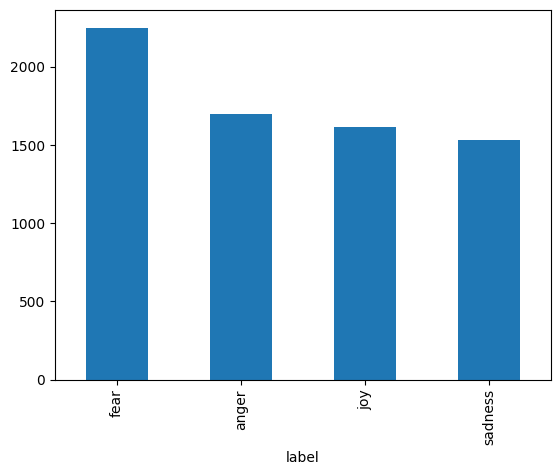

In [17]:
data['label'].value_counts().plot(kind='bar')

In [18]:
g = data.groupby('label')
data = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))

/tmp/ipython-input-18-2135407547.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))


<Axes: xlabel='label'>

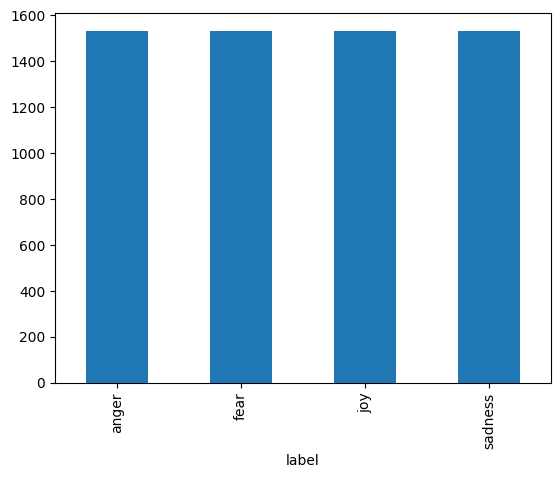

In [19]:
data['label'].value_counts().plot(kind='bar')

In [20]:
data['label_int'] = LabelEncoder().fit_transform(data['label'])

In [21]:
NUM_LABELS = 4

In [22]:
train_split, test_split = train_test_split(data, test_size=0.8)
train_split, val_split = train_test_split(train_split, test_size=0.9)

In [23]:
print(len(test_split))
print(len(test_split))
print(len(val_split))

4906
4906
1104


In [24]:
train_df = pd.DataFrame({
    "label": train_split.label_int.values,
    "text": train_split.text_clean.values
})
test_df = pd.DataFrame({
    "label": test_split.label_int.values,
    "text": test_split.text_clean.values
})

In [25]:
train_df = datasets.Dataset.from_dict(train_df)
test_df = datasets.Dataset.from_dict(test_df)

In [26]:
dataset_dict = datasets.DatasetDict({"train": train_df, "test": test_df})

In [27]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 122
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 4906
    })
})

CREATE EMBEDDINGS

In [28]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [29]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", max_length = 128, truncation=True)

In [30]:
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

Map:   0%|          | 0/122 [00:00<?, ? examples/s]

Map:   0%|          | 0/4906 [00:00<?, ? examples/s]

In [31]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 122
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4906
    })
})

In [32]:
print(tokenized_datasets['train']['text'][0])

 The thing is, it's either I be unproductive and unhappy, or deal with some videos that do badly.


In [33]:
print(tokenized_datasets['train']['input_ids'][0])

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 32, 554, 27, 19, 36, 26, 23, 725, 35, 39, 422, 19643, 21, 12729, 19, 49, 629, 33, 106, 5310, 29, 112, 5853, 9, 4, 3]


In [34]:
tokenizer.decode(5)

'<pad>'

In [35]:
print(tokenized_datasets['train']['token_type_ids'][0])

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]


In [37]:
print(tokenized_datasets['train']['attention_mask'][0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [39]:
small_train_dataset = tokenized_datasets['train'].shuffle(seed=42).select(range(122))
small_eval_dataset = tokenized_datasets['test'].shuffle(seed=42).select(range(1000))

FINETUNE OUR MODEL

In [40]:
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=NUM_LABELS, id2label={0: 'anger',1:'fear',2:'joy',3:'sadness'})

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
metric = evaluate.load("accuracy")

In [42]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [43]:
training_args = TrainingArguments(
    output_dir="test_trainer",
    eval_strategy="epoch",
    num_train_epochs=3)

In [44]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics
)

In [45]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bhuvanboddu08 (bhuvanboddu08-woxsen-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.441011,0.236000
2,No log,1.374080,0.326000
3,No log,1.398080,0.295000


TrainOutput(global_step=48, training_loss=1.403516451517741, metrics={'train_runtime': 179.0633, 'train_samples_per_second': 2.044, 'train_steps_per_second': 0.268, 'total_flos': 26066977892352.0, 'train_loss': 1.403516451517741, 'epoch': 3.0})

EVALUATION OF MODEL

In [46]:
trainer.evaluate()

{'eval_loss': 1.3980801105499268,
 'eval_accuracy': 0.295,
 'eval_runtime': 16.0495,
 'eval_samples_per_second': 62.307,
 'eval_steps_per_second': 7.788,
 'epoch': 3.0}

In [47]:
model.save_pretrained('my_fine_tuned_XLNet_model')

In [48]:
fine_tuned_model = XLNetForSequenceClassification.from_pretrained('my_fine_tuned_XLNet_model')

In [50]:
from transformers import pipeline

clf = pipeline("text-classification", model=fine_tuned_model, tokenizer=tokenizer)

Device set to use cuda:0


In [51]:
rand_int = random.randint(0, len(val_split))
print(val_split['text_clean'][rand_int])
answer = clf(val_split['text_clean'][rand_int])
print(answer)

No, just tweet pictures of four fictional characters who describe you. One should be an animated character. 
[{'label': 'sadness', 'score': 0.27882692217826843}]


/tmp/ipython-input-51-1276497668.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(val_split['text_clean'][rand_int])
/tmp/ipython-input-51-1276497668.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  answer = clf(val_split['text_clean'][rand_int])
